#Data analyses

## Load in the data

In [1]:
import numpy as np, sys, scipy.stats, pandas as pd, os, os.path, csv, PythonAnalyses

import matplotlib
import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline
pd.options.display.mpl_style = 'default'

Start = 0 #if I want to reload data from csvs = 1. If i want to load python pickle == 0

filename = 'AdditionalSingleton_TargetUncertain.csv'
csvName = 'AdditionalSingleton_TargetUncertain'

if sys.platform == 'linux2': #is this my linux laptop
    path = '/home/dan/Dropbox/TargetUncertainty/'
elif sys.platform == 'darwin': #is this my mac work comp    
    path = '/Users/danvatterott/Dropbox Encore/Dropbox/TargetUncertainty/'

os.chdir(path)

if Start == 1: #load in data from csv
    numfiles = len([name for name in os.listdir('.') if os.path.isfile(name) and name.endswith(".csv") and name[0].isdigit()])
    for partnum in xrange(1,numfiles+1): #this is a loop that goes through all participants
        filename = '%s_' % str(partnum) + csvName + '.csv'
        if partnum == 1: 
            df = pd.read_csv(filename)
        if partnum > 1: 
            df = df.append(pd.read_csv(filename))
    df.columns = map(str.lstrip, df.columns)
    df.to_pickle(csvName+'.pkl') #save this data frame all together
elif Start == 0: #load the data from a previously saved python file. should save time if not adding csv data. 
    df = pd.read_pickle(csvName+'.pkl')

In [2]:
df[0:3] #take a quick look at the dataframe. 

,TarType,TarLoc,TarColorCode,DistCond,TarDistDist,DistLoc,DistLine,Resp,Block,ConstantTar,Acc,RT,Sub#
0,1,4,3,1,0,0,0,1,0,0,1,1544.0347,1
1,2,4,3,1,0,0,0,2,0,0,1,1136.9638,1
2,2,1,4,2,1,2,2,2,0,0,1,658.4343,1


SingletonCueMatch = 1 = color singleton at cued location/object
SingletonCueMatch = 2 = color singleton at uncued location/object
SingletonCueMatch = 0 = color singleton absent
BlockType = 1 = cross
BlockType = 2 = circle
BlockType = 3 = cardinal
BlockType = 4 = diagonal

## Data Trimming

data trimming. correct, slower than 300 ms and faster than 1500. 

In [3]:
Trimmer = df['Block'] > 0 #not the practice block
Trimmer2 = df['Acc'] == 1 #not an error trial
Trimmer3 = df['RT'] > 300 #not a super fast response
PartTrim = (df['Sub#'] != 8)

DistCond = df[Trimmer & Trimmer2 & Trimmer3].groupby(['DistCond','Sub#']) 
RTTrim = DistCond['RT'].mean() + 2.5*DistCond['RT'].std(ddof=0)
subList = df.drop_duplicates(subset='Sub#')
TrimmerOld = [False]*len(df)
for sub in subList['Sub#']: #loop through every subject. 
    TrimmerA = (df.DistCond == 1) & (df['RT'] < RTTrim[1][sub]) & (df['Sub#'] == sub)
    TrimmerB = (df.DistCond == 2) & (df['RT'] < RTTrim[2][sub]) & (df['Sub#'] == sub)
    Trimmer4 = [any(tup) for tup in zip(TrimmerA, TrimmerB, TrimmerOld)] #combine those 2 RT trimmers. 
    TrimmerOld = Trimmer4

In [4]:
totalTrialNum = np.size(df[PartTrim & Trimmer],0)
ex_counter = 0
Total=0
for sub in df['Sub#'].unique(): #loop through every subject. 
    TrimmerA = (df[Trimmer].DistCond == 1) & (df[Trimmer]['RT'] > RTTrim[1][sub]) & (df[Trimmer]['Sub#'] == sub) & (df[Trimmer].Acc==1)
    TrimmerB = (df[Trimmer].DistCond == 2) & (df[Trimmer]['RT'] > RTTrim[2][sub]) & (df[Trimmer]['Sub#'] == sub) & (df[Trimmer].Acc==1)
    TrimmerC = df[Trimmer]['RT'] < 300 & (df[Trimmer].Acc==1)
    Total+= (sum(TrimmerA)+sum(TrimmerB)+sum(TrimmerC))
Total = sum(TrimmerA) + sum(TrimmerB) + sum(TrimmerC) 
print Total
print totalTrialNum
Rt_ex = float(Total)/float(totalTrialNum)
print '%.9f' % Rt_ex
#measuring how many trials are excluded.

14
11904
0.001176075


checking acc. looks good. everyone above 90%

In [5]:
tableAcc = df[Trimmer].pivot_table(values='Acc', index='Sub#', aggfunc=np.mean)
tableAcc

Sub#
1     0.955729
2     0.934896
3     0.927083
4     0.950521
5     0.963542
6     0.984375
7     0.958333
8     0.830729
9     0.966146
10    0.963542
11    0.971354
12    0.979167
13    0.955729
14    0.929688
15    0.947917
16    0.960938
17    0.914062
18    0.927083
19    0.966146
20    0.981771
21    0.984375
22    0.940104
23    0.966146
24    0.986979
25    0.955729
26    0.963542
27    0.945312
28    0.986979
29    0.979167
30    0.971354
31    0.984375
32    0.955729
Name: Acc, dtype: float64

## RT Data

----------------------------------------------------------------------------------------------------
Sub#			1			2			
1			782.06			794.97			
2			894.97			927.16			
3			813.94			837.38			
4			706.78			718.56			
5			694.97			726.68			
6			790.67			821.26			
7			717.9			724.11			
8			901.97			929.17			
9			773.09			787.07			
10			815.1			891.37			
11			729.72			750.74			
12			761.26			746.2			
13			569.67			580.64			
14			852.61			922.78			
15			680.24			700.85			
mean			765.66			790.6			
STE			22.5			25.64			
----------------------------------------------------------------------------------------------------
ttest = (-4.1899939873841046, 0.00090804020441020755)
n = 15


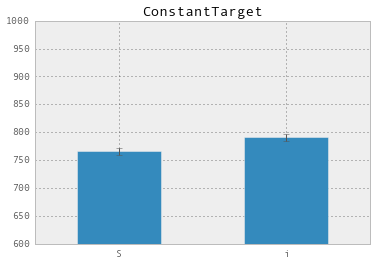

In [6]:
ConType = df['ConstantTar'] == 1
tableRT = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType].pivot_table(values='RT', index='Sub#', columns=['DistCond'], aggfunc=np.mean)
PythonAnalyses.dataTableRT(tableRT)

PythonAnalyses.Test_and_Plot_PairwiseComparison(tableRT, 600, 1000, 'Singleton Condition','ConstantTarget')

----------------------------------------------------------------------------------------------------
Sub#			1			2			
1			583.55			584.83			
2			789.49			803.06			
3			640.95			646.91			
4			753.48			715.25			
5			656.76			666.54			
6			768.4			768.62			
7			772.61			797.97			
8			654.97			669.04			
9			661.82			705.39			
10			925.16			896.72			
11			676.84			682.14			
12			622.57			583.33			
13			759.28			783.27			
14			658.63			650.66			
15			672.95			678.61			
16			688.78			703.85			
mean			705.39			708.51			
STE			21.02			20.88			
----------------------------------------------------------------------------------------------------
ttest = (-0.55330908980212878, 0.58820455277736239)
n = 16


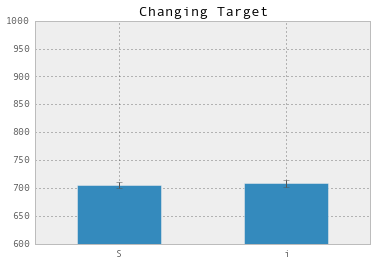

In [7]:
ConType = df['ConstantTar'] == 0
tableRT = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType].pivot_table(values='RT', index='Sub#', columns=['DistCond'], aggfunc=np.mean)
PythonAnalyses.dataTableRT(tableRT)

PythonAnalyses.Test_and_Plot_PairwiseComparison(tableRT, 600, 1000, 'Singleton Condition','Changing Target')

In [8]:
ConType = df['ConstantTar'] == 1
tableRT = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType].pivot_table(values='RT', index='Sub#', columns=['DistCond'], aggfunc=np.mean)
Diff_Constant = tableRT[2]-tableRT[1]
Absent1 = tableRT[1]
ConType = df['ConstantTar'] == 0
tableRT = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType].pivot_table(values='RT', index='Sub#', columns=['DistCond'], aggfunc=np.mean)
Diff_Change = tableRT[2]-tableRT[1]
Absent2 = tableRT[1]

print scipy.stats.ttest_ind(Diff_Constant, Diff_Change)
print scipy.stats.ttest_ind(Absent1, Absent2)

(2.6622204898030088, 0.012529004767109319)
(1.9594861824231018, 0.059730718743634538)


In [9]:
ConType = df['ConstantTar'] == 1
tableRT3 = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType].pivot_table(values='RT', index='Sub#', columns=[], aggfunc=np.mean)
ConType = df['ConstantTar'] == 0
tableRT4 = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType].pivot_table(values='RT', index='Sub#', columns=[], aggfunc=np.mean)

scipy.stats.ttest_ind(tableRT3, tableRT4)

(2.2533873531722675, 0.031967541533895631)

In [10]:
df['Col_prevTrial'] = df['TarColorCode'].shift(periods=1)
df['Col_prevTrial2'] = df['TarColorCode'].shift(periods=2)

In [11]:
df['Col_Rep'] = 0
df.loc[(df['Col_prevTrial'] == df['TarColorCode']), 'Col_Rep'] = 1
df.loc[(df['Col_prevTrial'] == df['TarColorCode']) & (df['Col_prevTrial2'] == df['TarColorCode']), 'Col_Rep1'] = 1

----------------------------------------------------------------------------------------------------
Sub#			1			2			
1			572.27			594.62			
2			784.45			762.95			
3			641.14			669.9			
4			764.51			705.41			
5			614.42			657.94			
6			798.59			771.3			
7			793.26			783.77			
8			651.19			683.88			
9			638.84			725.82			
10			914.82			901.9			
11			644.41			670.98			
12			608.67			588.11			
13			728.77			731.13			
14			646.59			688.13			
15			676.76			652.45			
16			680.53			689.13			
mean			697.45			704.84			
STE			22.82			19.15			
----------------------------------------------------------------------------------------------------
ttest = (-0.82030549783655715, 0.42488630411931783)
n = 16


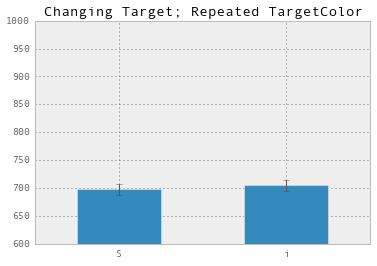

In [12]:
ConType = df['ConstantTar'] == 0
TarRep = df['Col_Rep'] == 1
tableRT = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType & TarRep].pivot_table(values='RT', index='Sub#', columns=['DistCond'], aggfunc=np.mean)
PythonAnalyses.dataTableRT(tableRT)

PythonAnalyses.Test_and_Plot_PairwiseComparison(tableRT, 600, 1000, 'Singleton Condition','Changing Target; Repeated TargetColor')

----------------------------------------------------------------------------------------------------
Sub#			1			2			
1			587.08			580.9			
2			790.9			815.73			
3			640.9			638.96			
4			749.5			719.01			
5			670.56			669.74			
6			760.44			767.88			
7			764.32			801.44			
8			656.32			664.2			
9			668.31			697.98			
10			928.86			895.56			
11			688.04			686.58			
12			627.55			581.78			
13			768.19			798.28			
14			662.27			640.02			
15			671.66			689.48			
16			692.33			709.04			
mean			707.95			709.79			
STE			20.64			21.71			
----------------------------------------------------------------------------------------------------
ttest = (-0.29746117947355577, 0.77019443213831074)
n = 16


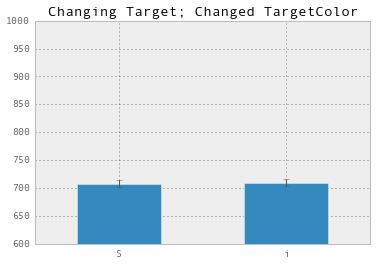

In [13]:
ConType = df['ConstantTar'] == 0
TarRep = df['Col_Rep'] == 0
tableRT = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType & TarRep].pivot_table(values='RT', index='Sub#', columns=['DistCond'], aggfunc=np.mean)
PythonAnalyses.dataTableRT(tableRT)

PythonAnalyses.Test_and_Plot_PairwiseComparison(tableRT, 600, 1000, 'Singleton Condition','Changing Target; Changed TargetColor')

In [14]:
ConType = df['ConstantTar'] == 1
DTRIM = df['DistCond'] == 1
tableRT2A = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & DTRIM & ConType].pivot_table(values='RT', index='Sub#', columns=['Block'], aggfunc=np.mean)
DTRIM = df['DistCond'] == 2
tableRT2B = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & DTRIM & ConType].pivot_table(values='RT', index='Sub#', columns=['Block'], aggfunc=np.mean)
ConType = df['ConstantTar'] == 0
DTRIM = df['DistCond'] == 1
tableRT2C = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & DTRIM & ConType].pivot_table(values='RT', index='Sub#', columns=['Block'], aggfunc=np.mean)
DTRIM = df['DistCond'] == 2
tableRT2D = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & DTRIM & ConType].pivot_table(values='RT', index='Sub#', columns=['Block'], aggfunc=np.mean)

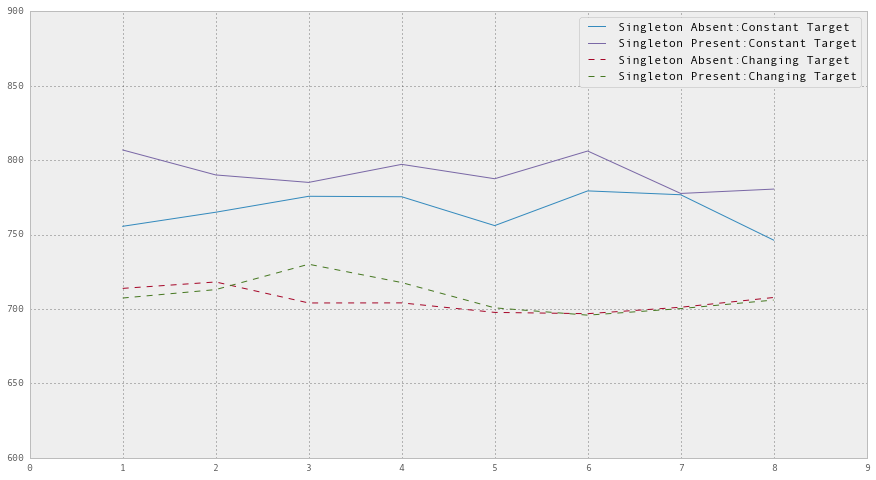

In [15]:
xdata = df['Block'][PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4].unique()

Absent1  = np.mean(tableRT2A)
Present1 = np.mean(tableRT2B)
Absent2  = np.mean(tableRT2C)
Present2 = np.mean(tableRT2D)

fig = plt.figure(figsize=(15,8))
axes = fig.add_subplot(111)

axes.plot(xdata, Absent1, label='Singleton Absent:Constant Target'); 
axes.plot(xdata, Present1, label='Singleton Present:Constant Target')
axes.plot(xdata, Absent2,'--', label='Singleton Absent:Changing Target'); 
axes.plot(xdata, Present2,'--', label='Singleton Present:Changing Target')
axes.legend()
axes.set_ylim(600,900)
axes.set_xlim(0,np.max(xdata)+1);

----------------------------------------------------------------------------------------------------
Sub#			1			2			
1			773.09			787.07			
2			729.72			750.74			
3			569.67			580.64			
4			680.24			700.85			
mean			688.18			704.83			
STE			43.82			45.01			
----------------------------------------------------------------------------------------------------
ttest = (-6.6916472223390606, 0.0068078990205718316)
n = 4


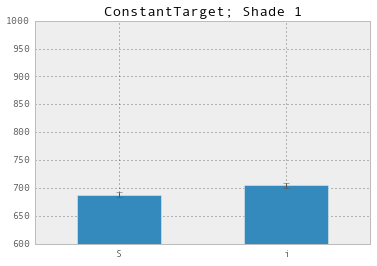

In [16]:
ConType = df['ConstantTar'] == 1
GreenShade = df['TarColorCode'] == 1 #this is the darkest green
tableRT = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType & GreenShade].pivot_table(values='RT', index='Sub#', columns=['DistCond'], aggfunc=np.mean)
PythonAnalyses.dataTableRT(tableRT)

PythonAnalyses.Test_and_Plot_PairwiseComparison(tableRT, 600, 1000, 'Singleton Condition','ConstantTarget; Shade 1')

----------------------------------------------------------------------------------------------------
Sub#			1			2			
1			782.06			794.97			
2			813.94			837.38			
3			706.78			718.56			
4			790.67			821.26			
mean			773.36			793.04			
STE			23.19			26.32			
----------------------------------------------------------------------------------------------------
ttest = (-4.3866101083997293, 0.021941336095399791)
n = 4


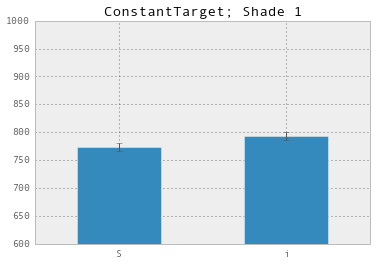

In [17]:
ConType = df['ConstantTar'] == 1
GreenShade = df['TarColorCode'] == 2 #this is the 2nd darkest green
tableRT = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType & GreenShade].pivot_table(values='RT', index='Sub#', columns=['DistCond'], aggfunc=np.mean)
PythonAnalyses.dataTableRT(tableRT)

PythonAnalyses.Test_and_Plot_PairwiseComparison(tableRT, 600, 1000, 'Singleton Condition','ConstantTarget; Shade 1')

----------------------------------------------------------------------------------------------------
Sub#			1			2			
1			901.97			929.17			
2			815.1			891.37			
3			761.26			746.2			
4			852.61			922.78			
mean			832.74			872.38			
STE			29.73			42.86			
----------------------------------------------------------------------------------------------------
ttest = (-1.865267068354896, 0.15899736033396084)
n = 4


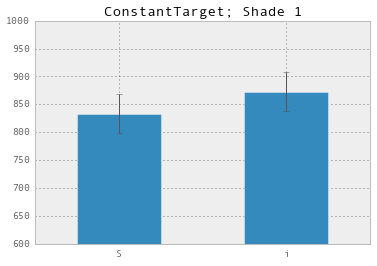

In [18]:
ConType = df['ConstantTar'] == 1
GreenShade = df['TarColorCode'] == 3 #this is the 2nd brightest green
tableRT = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType & GreenShade].pivot_table(values='RT', index='Sub#', columns=['DistCond'], aggfunc=np.mean)
PythonAnalyses.dataTableRT(tableRT)

PythonAnalyses.Test_and_Plot_PairwiseComparison(tableRT, 600, 1000, 'Singleton Condition','ConstantTarget; Shade 1')

----------------------------------------------------------------------------------------------------
Sub#			1			2			
1			894.97			927.16			
2			694.97			726.68			
3			717.9			724.11			
mean			769.28			792.65			
STE			63.19			67.26			
----------------------------------------------------------------------------------------------------
ttest = (-2.7236827616730239, 0.11250307924194093)
n = 3


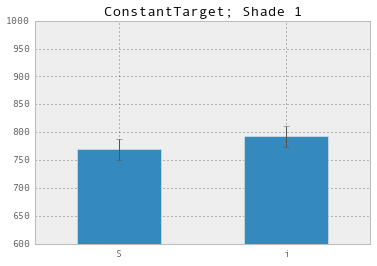

In [19]:
ConType = df['ConstantTar'] == 1
GreenShade = df['TarColorCode'] == 4 #this is the brightest green
tableRT = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType & GreenShade].pivot_table(values='RT', index='Sub#', columns=['DistCond'], aggfunc=np.mean)
PythonAnalyses.dataTableRT(tableRT)

PythonAnalyses.Test_and_Plot_PairwiseComparison(tableRT, 600, 1000, 'Singleton Condition','ConstantTarget; Shade 1')

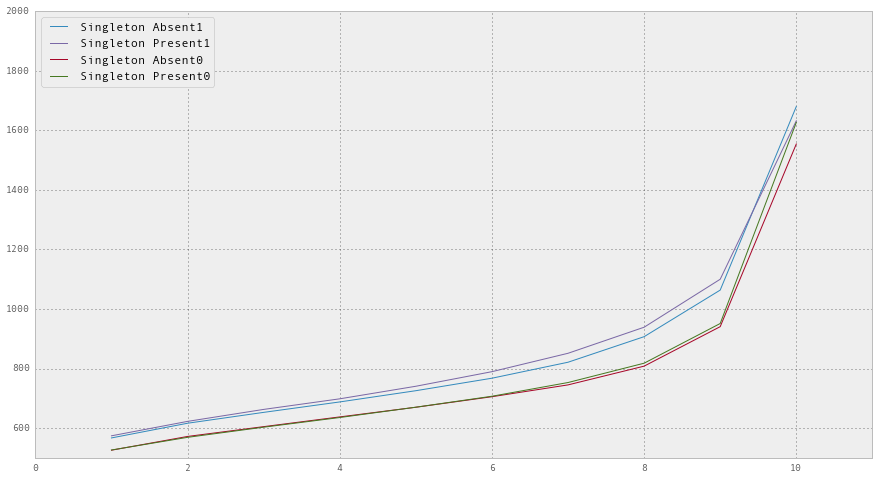

In [20]:
ConType = df['ConstantTar'] == 1
TrialT = df['DistCond'] == 1
RTs1 = df[Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & TrialT & ConType]['RT'].quantile(np.arange(0.1,1.1,0.1))
TrialT = df['DistCond'] == 2
RTs2 = df[Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & TrialT & ConType]['RT'].quantile(np.arange(0.1,1.1,0.1))
ConType = df['ConstantTar'] == 0
TrialT = df['DistCond'] == 1
RTs3 = df[Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & TrialT & ConType]['RT'].quantile(np.arange(0.1,1.1,0.1))
TrialT = df['DistCond'] == 2
RTs4 = df[Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & TrialT & ConType]['RT'].quantile(np.arange(0.1,1.1,0.1))
xdata = np.arange(1,11,1)

Singleton_Absent1  = RTs1
Singleton_Present1 = RTs2
Singleton_Absent0  = RTs3
Singleton_Present0 = RTs4

fig = plt.figure(figsize=(15,8))
axes = fig.add_subplot(111)

axes.plot(xdata, Singleton_Absent1, label='Singleton Absent1'); 
axes.plot(xdata, Singleton_Present1, label='Singleton Present1')
axes.plot(xdata, Singleton_Absent0, label='Singleton Absent0'); 
axes.plot(xdata, Singleton_Present0, label='Singleton Present0')
axes.legend(loc=2)
axes.set_ylim(500,2000)
axes.set_xlim(0,11);

In [53]:
def print_tests(series1, series2):
    normTest = scipy.stats.shapiro(series1-series2)
    Test = scipy.stats.ttest_rel(series1,series2)
    print '\t normality test. Test value: %s P-value: %s' % (str(np.round(normTest[0],2)), str(np.round(normTest[1],4)))
    print '\t T-test. Test value: %s P-value: %s' % (str(np.round(Test[0],2)), str(np.round(Test[1],4)))
    
def GroupCapAnalysis_and_Plot(tableRT2, CIs):
    PlotFrame = pd.DataFrame([tableRT2.mean()])
    PlotFrame.columns = ['Incongruent', 'Congruent']
    PlotFrame2 = pd.DataFrame()
    PlotFrame2['Congruent'] = pd.DataFrame([CIs])
    PlotFrame2['Incongruent'] = pd.DataFrame([CIs])
    PlotFrame.plot(ylim = [500, 900], yerr=PlotFrame2, kind='bar')
    plt.xticks(range(1), ['Congruency of Singleton Line'], rotation=0);

    disp_tab = np.round(tableRT2,2)
    disp_tab['Incong-cong'] = disp_tab[False] - disp_tab[True]
    print disp_tab

    print '---------------------------------'
    print 'Mean Congruent: %s' % (str(round(np.mean(tableRT2[True]),2)))
    print 'Mean Incongruent: %s' % (str(round(np.mean(tableRT2[False]),2)))
    print 'Incongruent - Congruent: %s' % (str(round(np.mean(tableRT2[False])-np.mean(tableRT2[True]),2)))
    print '---------------------------------'
    print 'Neutral vs Singleton Distractor'
    print_tests(tableRT2[True],tableRT2[False])
    
def SimpleComparisonCI(table):
    import scipy.stats, math
    ttest = scipy.stats.ttest_rel(table[True], table[False])
    MeanDiff_byT = abs((table[False].mean()-table[True].mean())/ttest[0])
    CI = MeanDiff_byT*scipy.stats.t.isf(0.025, len(table)-1)*math.pow(2,0.05)/2
    return CI

Cong   False    True  Incong-cong
Sub#                             
2     804.57  786.21        18.36
4     928.98  924.81         4.17
6     819.83  854.55       -34.72
10    713.41  724.38       -10.97
12    737.97  716.80        21.17
14    806.79  837.50       -30.71
16    728.01  718.99         9.02
18    920.47  936.72       -16.25
20    776.46  795.57       -19.11
22    894.88  887.01         7.87
24    759.62  742.35        17.27
26    739.85  754.23       -14.38
28    578.72  582.38        -3.66
30    911.02  931.83       -20.81
32    698.92  702.89        -3.97
---------------------------------
Mean Congruent: 793.08
Mean Incongruent: 787.97
Incongruent - Congruent: -5.12
---------------------------------
Neutral vs Singleton Distractor
	 normality test. Test value: 0.96 P-value: 0.6283
	 T-test. Test value: 1.12 P-value: 0.2836


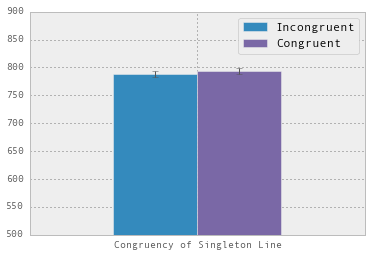

In [54]:
ConType = df['ConstantTar'] == 1
TrialT = df['DistCond'] == 2
df['Cong'] = (df['TarType'] == df['DistLine'])

tableRT = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType & TrialT].pivot_table(values='RT', index='Sub#', columns=['Cong'], aggfunc=np.mean)
CIs = SimpleComparisonCI(tableRT)
GroupCapAnalysis_and_Plot(tableRT, CIs)

Cong   False    True  Incong-cong
Sub#                             
1     587.88  581.85         6.03
3     815.14  792.41        22.73
5     650.72  642.97         7.75
7     722.05  708.62        13.43
9     678.61  655.86        22.75
11    775.28  762.17        13.11
13    808.88  787.06        21.82
15    681.10  654.76        26.34
17    708.96  701.61         7.35
19    916.25  880.73        35.52
21    662.20  700.43       -38.23
23    583.65  582.94         0.71
25    798.65  771.12        27.53
27    644.68  655.83       -11.15
29    679.80  677.55         2.25
31    703.99  703.72         0.27
---------------------------------
Mean Congruent: 703.73
Mean Incongruent: 713.62
Incongruent - Congruent: 9.89
---------------------------------
Neutral vs Singleton Distractor
	 normality test. Test value: 0.91 P-value: 0.1302
	 T-test. Test value: -2.22 P-value: 0.0421


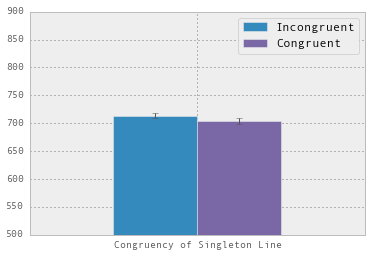

In [55]:
ConType = df['ConstantTar'] == 0
TrialT = df['DistCond'] == 2
df['Cong'] = (df['TarType'] == df['DistLine'])

tableRT = df[PartTrim & Trimmer & Trimmer2 & Trimmer3 & Trimmer4 & ConType & TrialT].pivot_table(values='RT', index='Sub#', columns=['Cong'], aggfunc=np.mean)
CIs = SimpleComparisonCI(tableRT)
GroupCapAnalysis_and_Plot(tableRT, CIs)